In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import spacy
from wordcloud import WordCloud
from textstat import flesch_reading_ease
import traceback
import sys

In [2]:
# Configuración visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Descarga de recursos

In [3]:
def download_nltk_resources():
    """Descarga todos los recursos necesarios de NLTK."""
    resources = [
        'punkt',
        'punkt_tab', 
        'stopwords',
        'averaged_perceptron_tagger',
        'wordnet'
    ]
    print("Descargando recursos de NLTK...")
    print("="*40)
    for resource in resources:
        try:
            nltk.download(resource, quiet=False)
            print(f" {resource} descargado correctamente")
        except Exception as e:
            print(f"  Error descargando {resource}: {e}")
    print("\n Configuración completada.-")

In [4]:
# Descarga los recursos de NLTK antes de continuar
download_nltk_resources()

Descargando recursos de NLTK...
 punkt descargado correctamente
 punkt_tab descargado correctamente
 stopwords descargado correctamente
 averaged_perceptron_tagger descargado correctamente
 wordnet descargado correctamente

 Configuración completada.-


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorgevaldez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jorgevaldez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgevaldez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jorgevaldez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jorgevaldez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
#from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [6]:
# Cargar modelo de spaCy para español
try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("Modelo de spacy para español no encontrado. Instalalo con: python -m spacy download es_core_news_sm")
    nlp = None

# Recursos de NLTK
STOP_WORDS_ES = set(stopwords.words('spanish')) # Lista de stopwords en español
#LEMMATIZER = WordNetLemmatizer() # Lematizador de NLTK, su función es reducir palabras a su forma base
#STEMMER = SnowballStemmer('spanish') # Stemmer de NLTK para español, sirve para reducir palabras a su raíz


### Funciones de Análisis y Preprocesamiento

In [7]:
def load_novels(corpus_directory):
    """Carga todas las novelas desde archivos .txt en un directorio."""
    print("Cargando novelas desde archivos...")
    novels = {}
    for filename in os.listdir(corpus_directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(corpus_directory, filename)
            novel_name = os.path.splitext(filename)[0]
            try:
                with open(filepath, 'r', encoding='utf-8') as file:
                    content = file.read()
                    novels[novel_name] = content
                    print(f"    - Cargada: {novel_name}")
            except Exception as e:
                print(f"✗ Error cargando {filename}: {e}")
    print(f"\nTotal de novelas cargadas: {len(novels)}")
    return novels

def calculate_basic_statistics(novels):
    """Calcula estadísticas básicas para cada novela en el corpus."""
    print("\n" + "="*50)
    print("ANÁLISIS ESTADÍSTICO")
    print("="*50)
    stats_data = []
    stats_dict = {}
    for novel_name, content in novels.items():
        char_count = len(content)
        char_count_no_spaces = len(content.replace(' ', ''))
        word_count = len(content.split())
        sentences = sent_tokenize(content)
        sentence_count = len(sentences)
        paragraph_count = len([p for p in content.split('\n\n') if p.strip()])
        words = word_tokenize(content.lower())
        words_clean = [w for w in words if w.isalpha()]
        unique_words = len(set(words_clean))
        avg_words_per_sentence = word_count / sentence_count if sentence_count > 0 else 0
        avg_chars_per_word = char_count_no_spaces / word_count if word_count > 0 else 0
        try:
            readability = flesch_reading_ease(content)
        except:
            readability = 0
        
        stats = {
            'Novela': novel_name,
            'Caracteres': char_count,
            'Caracteres (sin espacios)': char_count_no_spaces,
            'Palabras': word_count,
            'Palabras únicas': unique_words,
            'Oraciones': sentence_count,
            'Párrafos': paragraph_count,
            'Prom. palabras/oración': round(avg_words_per_sentence, 2),
            'Prom. caracteres/palabra': round(avg_chars_per_word, 2),
            'Índice de legibilidad': round(readability, 2),
            'Diversidad léxica': round(unique_words / word_count, 4) if word_count > 0 else 0
        }
        stats_data.append(stats)
        stats_dict[novel_name] = stats

    df_stats = pd.DataFrame(stats_data)
    print("\nEstadísticas por novela:")
    print(df_stats.to_string(index=False))
    
    total_words = sum(s['Palabras'] for s in stats_data)
    total_chars = sum(s['Caracteres'] for s in stats_data)
    total_sentences = sum(s['Oraciones'] for s in stats_data)
    
    print(f"\n" + "-"*30)
    print("ESTADÍSTICAS DEL CORPUS")
    print("-"*30)
    print(f"Total de palabras: {total_words}")
    print(f"Total de caracteres: {total_chars}")
    print(f"Total de oraciones: {total_sentences}")
    print(f"Promedio de palabras por novela: {total_words/len(novels):.0f}")
    
    return df_stats, stats_dict

def visualize_statistics(df_stats, graficas_directory):
    """Crea y guarda visualizaciones de las estadísticas del corpus."""
    print("\nGenerando visualizaciones...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis estadístico del corpus de novelas', fontsize=16, fontweight='bold')
    
    novel_names = df_stats['Novela']
    
    # Se añade una clave 'format' para mejorar la visualización de los valores
    plots_config = [
        {'col': 'Palabras', 'ax': axes[0, 0], 'title': 'Número de palabras por novela', 'color': 'skyblue', 'format': '{:,.0f}'},
        {'col': 'Diversidad léxica', 'ax': axes[0, 1], 'title': 'Diversidad léxica por novela', 'color': 'lightcoral', 'format': '{:.3f}'},
        {'col': 'Prom. palabras/oración', 'ax': axes[0, 2], 'title': 'Promedio de palabras por oración', 'color': 'lightgreen', 'format': '{:.2f}'},
        {'col': 'Oraciones', 'ax': axes[1, 0], 'title': 'Número de oraciones por novela', 'color': 'gold', 'format': '{:,.0f}'},
        {'col': 'Índice de legibilidad', 'ax': axes[1, 1], 'title': 'Índice de legibilidad (Flesch)', 'color': 'plum', 'format': '{:.2f}'}
    ]

    for config in plots_config:
        ax = config['ax']
        data = df_stats[config['col']]
        bars = ax.bar(novel_names, data, color=config['color'])
        ax.set_title(config['title'])
        ax.set_xlabel('Novelas')
        ax.set_ylabel(config['col'].replace('_', ' '))
        ax.set_xticks(np.arange(len(novel_names)))
        ax.set_xticklabels(novel_names, rotation=45, ha='right')

        # Se mejora el formato del texto sobre las barras
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, config['format'].format(yval), ha='center', va='bottom', fontsize=8)

    # Gráfico: Comparamos palabras vs palabras únicas
    ax6 = axes[1, 2]
    x = np.arange(len(novel_names))
    width = 0.35
    ax6.bar(x - width/2, df_stats['Palabras'], width, label='Total palabras', alpha=0.8)
    ax6.bar(x + width/2, df_stats['Palabras únicas'], width, label='Palabras únicas', alpha=0.8)
    ax6.set_title('Palabras totales vs únicas')
    ax6.set_xlabel('Novelas')
    ax6.set_ylabel('Número de palabras')
    ax6.set_xticks(x)
    ax6.set_xticklabels(novel_names, rotation=45, ha='right')
    ax6.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(graficas_directory, 'estadisticas_corpus.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
def perform_frequency_analysis(novels, stop_words, graficas_directory, top_n=20):
    """Realiza un análisis de frecuencia de términos en todo el corpus y por novela."""
    print("\n" + "="*50)
    print("ANÁLISIS DE FRECUENCIA DE TÉRMINOS")
    print("="*50)
    
    all_words = []
    novel_frequencies = {}
    
    for novel_name, content in novels.items():
        words = word_tokenize(content.lower())
        words_clean = [w for w in words if w.isalpha() and len(w) > 2]
        words_no_stop = [w for w in words_clean if w not in stop_words]
        novel_frequencies[novel_name] = Counter(words_no_stop)
        all_words.extend(words_no_stop)
    
    global_frequencies = Counter(all_words)
    
    print(f"\nPalabras más frecuentes en todo el corpus (top {top_n}):")
    print("-" * 50)
    for word, freq in global_frequencies.most_common(top_n):
        print(f"{word:20} | {freq:6} apariciones")
    
    top_words = [word for word, _ in global_frequencies.most_common(top_n)]
    top_freqs = [freq for _, freq in global_frequencies.most_common(top_n)]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(top_words, top_freqs, color='steelblue')
    plt.title(f'Top {top_n} Palabras más frecuentes en el corpus', fontsize=14, fontweight='bold')
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(os.path.join(graficas_directory, 'frecuencias_globales.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return global_frequencies, novel_frequencies

def generate_wordcloud_from_freq(global_frequencies, graficas_directory):
    """Genera y guarda una nube de palabras a partir de las frecuencias globales."""
    print("\nGenerando nube de palabras...")
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', colormap='viridis',
        max_words=100, relative_scaling=0.5, random_state=42
    ).generate_from_frequencies(global_frequencies)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras del corpus de novelas', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(graficas_directory, 'wordcloud_corpus.png'), dpi=300, bbox_inches='tight')
    plt.show()

def calculate_lexical_similarity(novel_frequencies):
    """Calcula una matriz de similitud léxica (Jaccard) entre novelas."""
    novel_names = list(novel_frequencies.keys())
    n = len(novel_names)
    similarity_matrix = np.zeros((n, n))
    
    for i, novel1 in enumerate(novel_names):
        for j, novel2 in enumerate(novel_names):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                words1 = set(novel_frequencies[novel1].keys())
                words2 = set(novel_frequencies[novel2].keys())
                intersection = len(words1.intersection(words2))
                union = len(words1.union(words2))
                jaccard_similarity = intersection / union if union > 0 else 0
                similarity_matrix[i, j] = jaccard_similarity
    
    return pd.DataFrame(similarity_matrix, index=novel_names, columns=novel_names)

def perform_comparative_analysis(novels, novel_frequencies, graficas_directory):
    """Realiza un análisis comparativo entre las novelas del corpus."""
    print("\n" + "="*50)
    print("ANÁLISIS COMPARATIVO ENTRE NOVELAS")
    print("="*50)
    
    novel_names = list(novels.keys())
    unique_words_analysis = {}
    
    for novel_name in novel_names:
        words_in_novel = set(novel_frequencies[novel_name].keys())
        words_in_others = set().union(*(novel_frequencies[other].keys() for other in novel_names if other != novel_name))
        unique_words = words_in_novel - words_in_others
        unique_words_analysis[novel_name] = {'unique_words': unique_words, 'count': len(unique_words)}
    
    print("\nPalabras únicas por novela:")
    for novel_name, data in unique_words_analysis.items():
        print(f"\n{novel_name}: {data['count']} palabras únicas")
        if data['count'] > 0:
            print(f"  Ejemplos: {', '.join(list(data['unique_words'])[:10])}")
    
    print("\nCalculando similitud léxica entre novelas...")
    similarity_matrix = calculate_lexical_similarity(novel_frequencies)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='Blues', square=True, fmt='.3f', cbar_kws={'label': 'Similitud léxica (Jaccard)'})
    plt.title('Matriz de similitud léxica entre novelas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(graficas_directory, 'similitud_lexica.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return unique_words_analysis, similarity_matrix

def preprocess_text_for_rag(text: str) -> str:
    """
    Realiza una limpieza ligera del texto, conservando la estructura de oraciones y párrafos.
    Esta función está diseñada para preparar el texto para sistemas RAG (Retrieval-Augmented Generation),
    donde el contexto, la semántica y la estructura original son cruciales para el chunking y la
    generación de embeddings de alta calidad.

    Args:
        text (str): El texto original de la novela.

    Returns:
        str: El texto con limpieza mínima, listo para ser procesado por el siguiente script.
    """
    
    processed_text = re.sub(r'\n{3,}', '\n\n', text)
    
    processed_text = re.sub(r' +', ' ', processed_text)

    lines = processed_text.split('\n')
    stripped_lines = [line.strip() for line in lines]
    processed_text = '\n'.join(stripped_lines)

    return processed_text.strip()

def save_corpus_and_stats(corpus_to_save: dict, stats_dict: dict, output_directory: str, estadisticas_directory: str):
    """
    Guarda el corpus (con limpieza ligera para RAG) en archivos de texto y las estadísticas en un CSV.
    
    Args:
        corpus_to_save (dict): Diccionario con los textos listos para RAG.
        stats_dict (dict): Diccionario con las estadísticas calculadas.
        output_directory (str): Directorio para guardar los archivos .txt procesados.
        estadisticas_directory (str): Directorio para guardar el archivo .csv de estadísticas.
    """
    print(f"\nGuardando corpus para RAG en: {output_directory}")
    os.makedirs(output_directory, exist_ok=True)
    
    for novel_name, content in corpus_to_save.items():
        filename = f"{novel_name}_processed.txt"
        filepath = os.path.join(output_directory, filename)
        with open(filepath, 'w', encoding='utf-8') as file:
            file.write(content)
        print(f"✓ Guardado: {filename}")
        
    if stats_dict:
        stats_df = pd.DataFrame.from_dict(stats_dict, orient='index')
        stats_csv_path = os.path.join(estadisticas_directory, 'estadisticas_corpus.csv')
        stats_df.to_csv(stats_csv_path)
        print(f"✓ Estadísticas guardadas en: {stats_csv_path}")

### Cuerpo principal

In [8]:
# Configuración de directorios
graficas_directory = "graficos"
estadisticas_directory = "estadisticas"
output_directory = "corpus_procesado"
corpus_directory = "novelas_txt" #"../novelas_txt"  # Se deberá cambiar por el directorio correcto

os.makedirs(graficas_directory, exist_ok=True)
os.makedirs(estadisticas_directory, exist_ok=True)
   

### Carga de corpus

In [9]:
try:
    novels_data = load_novels(corpus_directory)
    if not novels_data:
        print("  No se encontraron archivos .txt en el directorio especificado. Finalizando ejecución.")
        sys.exit(1)
except FileNotFoundError:
    print(f"\nERROR: El directorio del corpus '{corpus_directory}' no fue encontrado.")
    print("Por favor, asegúrate de que la ruta sea correcta y que contenga archivos .txt.")
    sys.exit(1)

Cargando novelas desde archivos...
    - Cargada: La_de_Bringas_314648
    - Cargada: Pepita_Jimenez_pg17223
    - Cargada: La_desheredada_pg25956
    - Cargada: El_sombrero_de_tres_picos_pg29506
    - Cargada: Los_pazos_de_Ulloa_18005-8_UTF8
    - Cargada: Pen╠âas_arriba_pg24127
    - Cargada: Tristana_pg66979
    - Cargada: Su_unico_hijo_pg17341
    - Cargada: Platero_y_yo_pg9980
    - Cargada: La_gaviota_pg23600

Total de novelas cargadas: 10


### Analisis

In [10]:
# Analisis estadístico
df_statistics, corpus_stats_dict = calculate_basic_statistics(novels_data)


ANÁLISIS ESTADÍSTICO

Estadísticas por novela:
                           Novela  Caracteres  Caracteres (sin espacios)  Palabras  Palabras únicas  Oraciones  Párrafos  Prom. palabras/oración  Prom. caracteres/palabra  Índice de legibilidad  Diversidad léxica
             La_de_Bringas_314648      433852                     365965     74351            12122       3531       921                   21.06                      4.92                  53.20             0.1630
           Pepita_Jimenez_pg17223      334282                     277668     59840            10003       2647       970                   22.61                      4.64                  50.95             0.1672
           La_desheredada_pg25956      841679                     711395    143102            18424       8789      2867                   16.28                      4.97                  55.84             0.1287
El_sombrero_de_tres_picos_pg29506      444681                     381667     70730            10969 


Generando visualizaciones...


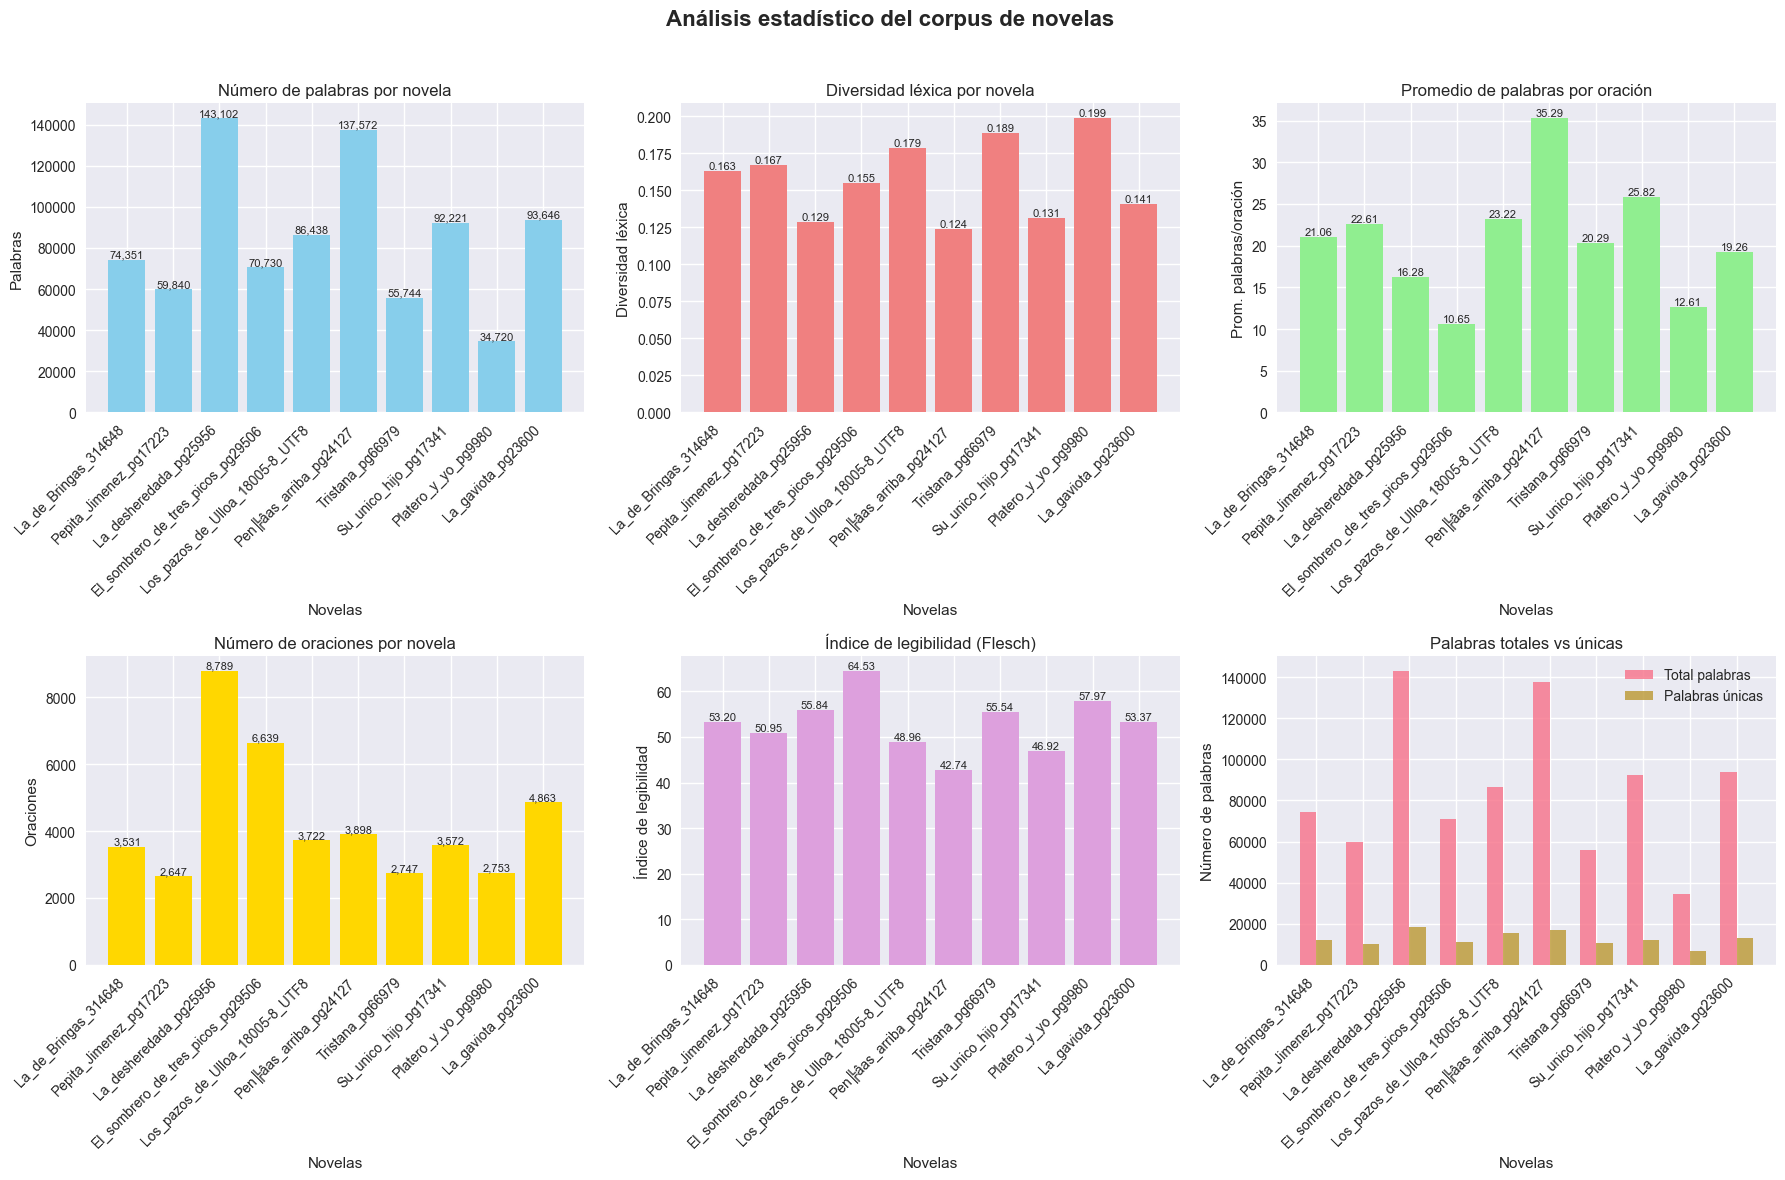

In [11]:
# Visualizaciones estadísticas
visualize_statistics(df_statistics, graficas_directory)
    


ANÁLISIS DE FRECUENCIA DE TÉRMINOS

Palabras más frecuentes en todo el corpus (top 20):
--------------------------------------------------
the                  |   3582 apariciones
tan                  |   1921 apariciones
usted                |   1800 apariciones
dijo                 |   1451 apariciones
bien                 |   1413 apariciones
casa                 |   1245 apariciones
dos                  |   1233 apariciones
and                  |   1197 apariciones
ser                  |   1138 apariciones
aquel                |   1124 apariciones
pues                 |   1044 apariciones
don                  |    990 apariciones
aquella              |    987 apariciones
después              |    970 apariciones
día                  |    885 apariciones
project              |    881 apariciones
dios                 |    874 apariciones
hombre               |    865 apariciones
así                  |    839 apariciones
mismo                |    826 apariciones


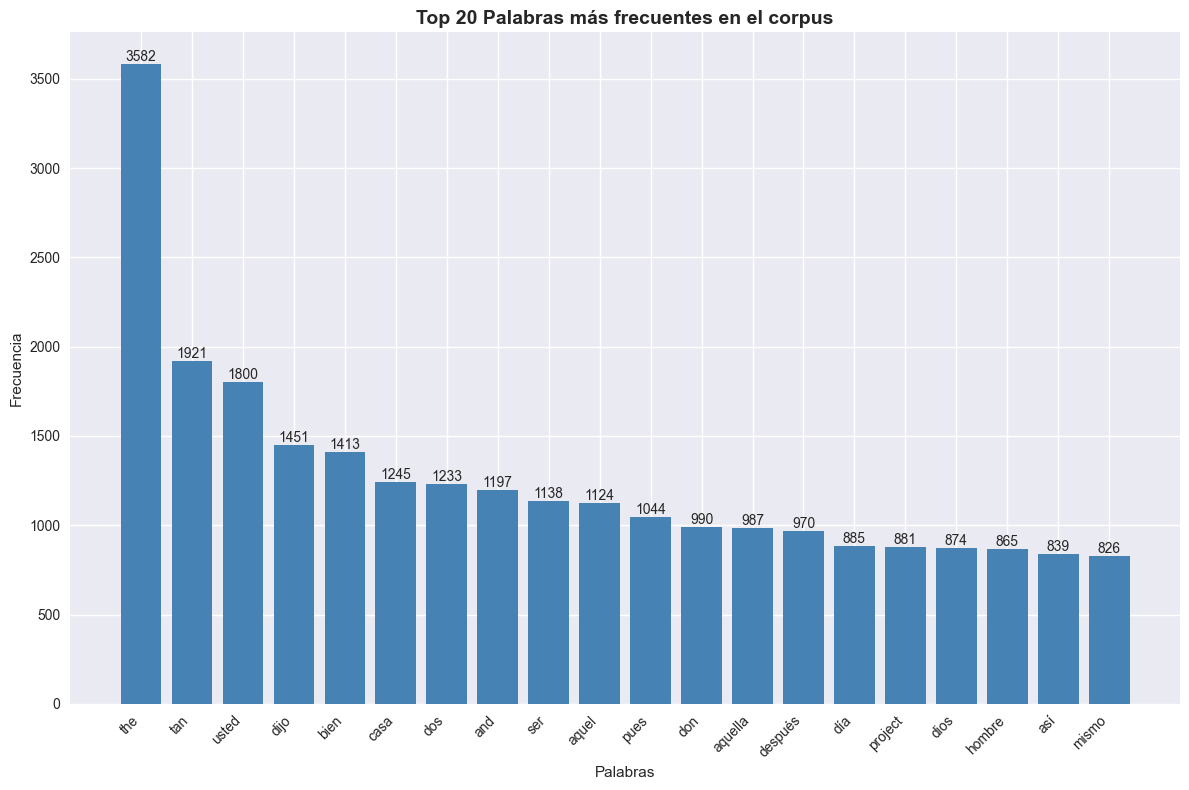

In [12]:
# Análisis de frecuencia
global_freqs, novel_freqs = perform_frequency_analysis(novels_data, STOP_WORDS_ES, graficas_directory)



Generando nube de palabras...


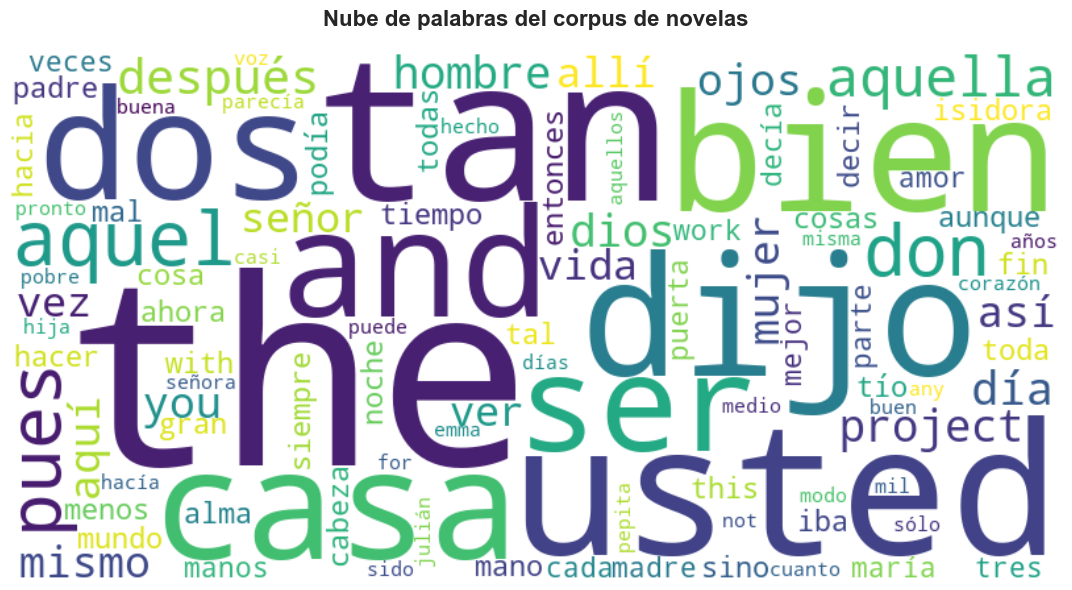

In [13]:
# Nube de palabras
generate_wordcloud_from_freq(global_freqs, graficas_directory)


ANÁLISIS COMPARATIVO ENTRE NOVELAS

Palabras únicas por novela:

La_de_Bringas_314648: 2196 palabras únicas
  Ejemplos: habríale, utilizaremos, sumaban, barbián, trapajo, secretearon, formados, incorrecta, caobas, saldrán

Pepita_Jimenez_pg17223: 1804 palabras únicas
  Ejemplos: absorba, deseable, tiana, denuesto, cosméticos, convertirlos, exprese, revolverán, jardincillo, embozados

La_desheredada_pg25956: 4501 palabras únicas
  Ejemplos: muladar, arrugadito, veraniega, castañetas, instruirse, divertiría, enfadaban, manchego, arancel, desperezó

El_sombrero_de_tres_picos_pg29506: 4155 palabras únicas
  Ejemplos: sculptural, italian, jesting, ios, anne, renewed, bajes, charger, wrinkle, nativity

Los_pazos_de_Ulloa_18005-8_UTF8: 3630 palabras únicas
  Ejemplos: medra, oscurecía, regalas, sucedería, marcelina, despachaderas, maman, dudará, amenguando, perjure

Pen╠âas_arriba_pg24127: 5091 palabras únicas
  Ejemplos: inclinéme, desnudándose, parapeto, idénticos, aldeúca, observólo, dele

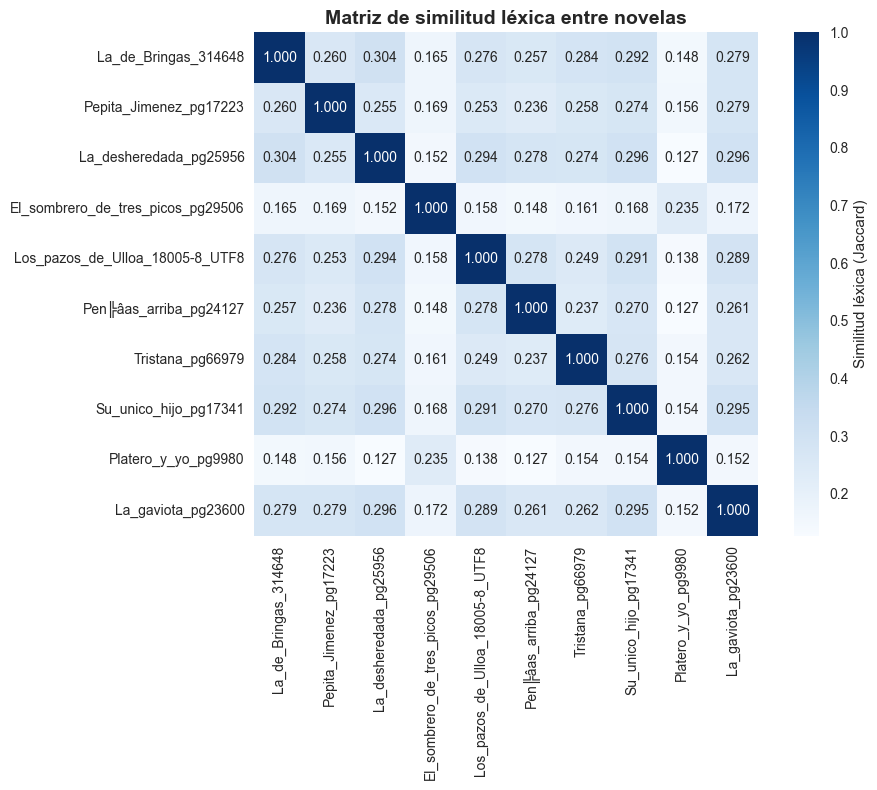

In [14]:
# Análisis comparativo
unique_analysis, similarity_mat = perform_comparative_analysis(novels_data, novel_freqs, graficas_directory)    

In [15]:
# APLICAR PREPROCESAMIENTO LIGERO PARA RAG
# Este es el paso nuevo y crucial. Creamos una nueva versión de los textos
# que será la que se guarde para el siguiente script.
print("\n" + "="*50)
print("GENERANDO CORPUS CON LIMPIEZA LIGERA PARA RAG")
print("="*50)
rag_ready_corpus = {}
for novel_name, content in novels_data.items():
    rag_ready_corpus[novel_name] = preprocess_text_for_rag(content)
    print(f"✓ Texto para RAG generado para: {novel_name}")


GENERANDO CORPUS CON LIMPIEZA LIGERA PARA RAG
✓ Texto para RAG generado para: La_de_Bringas_314648
✓ Texto para RAG generado para: Pepita_Jimenez_pg17223
✓ Texto para RAG generado para: La_desheredada_pg25956
✓ Texto para RAG generado para: El_sombrero_de_tres_picos_pg29506
✓ Texto para RAG generado para: Los_pazos_de_Ulloa_18005-8_UTF8
✓ Texto para RAG generado para: Pen╠âas_arriba_pg24127
✓ Texto para RAG generado para: Tristana_pg66979
✓ Texto para RAG generado para: Su_unico_hijo_pg17341
✓ Texto para RAG generado para: Platero_y_yo_pg9980
✓ Texto para RAG generado para: La_gaviota_pg23600


In [16]:
# Guardar el corpus con limpieza ligera y las estadísticas
save_corpus_and_stats(rag_ready_corpus, corpus_stats_dict, output_directory, estadisticas_directory)

print(f"\n¡Análisis completado exitosamente!")
print(f"  - Archivos de corpus procesado guardados en: {output_directory}")
print(f"  - Gráficas guardadas en: {graficas_directory}")
print(f"  - Estadísticas guardadas en: {estadisticas_directory}")
    


Guardando corpus para RAG en: corpus_procesado
✓ Guardado: La_de_Bringas_314648_processed.txt
✓ Guardado: Pepita_Jimenez_pg17223_processed.txt
✓ Guardado: La_desheredada_pg25956_processed.txt
✓ Guardado: El_sombrero_de_tres_picos_pg29506_processed.txt
✓ Guardado: Los_pazos_de_Ulloa_18005-8_UTF8_processed.txt
✓ Guardado: Pen╠âas_arriba_pg24127_processed.txt
✓ Guardado: Tristana_pg66979_processed.txt
✓ Guardado: Su_unico_hijo_pg17341_processed.txt
✓ Guardado: Platero_y_yo_pg9980_processed.txt
✓ Guardado: La_gaviota_pg23600_processed.txt
✓ Estadísticas guardadas en: estadisticas/estadisticas_corpus.csv

¡Análisis completado exitosamente!
  - Archivos de corpus procesado guardados en: corpus_procesado
  - Gráficas guardadas en: graficos
  - Estadísticas guardadas en: estadisticas
